In [56]:
#  import libraries
import h5py
import os, sys
import zipfile
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

# --- Configuration ---
sys.path.insert(0, '../../../config')
from _utility_imports import *

In [11]:
# Path to the ZIP file
# check if .zip file exists
if not os.path.exists("results.zip"):
    print("The file 'results.zip' does not exist.")
    sys.exit()
    
zip_file_path = "results.zip"
output_folder = "results"

# Unzip the file
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Create the output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        zip_ref.extractall(output_folder)
    print(f"Extracted '{zip_file_path}' to '{output_folder}'")
else:
    print(f"The file '{zip_file_path}' does not exist.")


Extracted 'results.zip' to 'results'


Reading data from results/true-wrong-icepack.h5...
Dataset 'Lxy' extracted with shape (2,)
Dataset 'b_io' extracted with shape (2,)
Dataset 'nxy' extracted with shape (2,)
Dataset 'obs_index' extracted with shape (2,)
Dataset 'obs_max_time' extracted with shape (1,)
Dataset 'statevec_nurged' extracted with shape (2772, 6)
Dataset 'statevec_true' extracted with shape (2772, 6)
Dataset 't' extracted with shape (6,)
Dataset 'w' extracted with shape (2772, 2)
Data extraction complete.
At h_indx = 3 profile 
(2,)


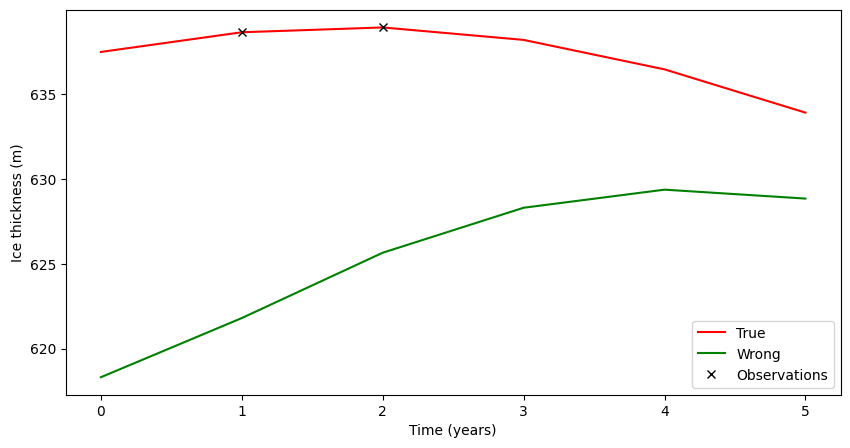

In [105]:
filter_type = "true-wrong"
file_path = f"results/{filter_type}-icepack.h5"
datasets_tw = extract_datasets_from_h5(file_path)
t=datasets_tw['t']
statevec_true = datasets_tw['statevec_true']
statevec_nurged = datasets_tw['statevec_nurged']
w = datasets_tw['w']
ind_m = datasets_tw['obs_index']
tm_m = datasets_tw['obs_max_time'][0]

nt = statevec_true.shape[1]; num_steps = nt-1
ndim = statevec_true.shape[0]
hdim = ndim//4

# plot the statevec_true and statevec_nurged
htrue = statevec_true[:hdim,:]
hnurge = statevec_nurged[:hdim,:]

# h_indx = 0 # first profile
h_indx = htrue.shape[1]//2 # middle profile
# h_indx = htrue.shape[1]-1 # last profile
# h_indx = np.random.randint(htrue.shape[1])  # random profile
print(f"At h_indx = {h_indx} profile ")

h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]

plt.figure(figsize=(10,5))
plt.plot(t,h_true,'r',label='True')
plt.plot(t,h_nurged,'g',label='Wrong')
obs = w[h_indx,:]; print(obs.shape)
plt.plot(t[ind_m],obs,'kx',label="Observations")
plt.xlabel('Time (years)')
plt.ylabel('Ice thickness (m)')
plt.legend()

In [68]:
# plt.plot(t[ind_m],w[hdim:,:].T)
w[:hdim,:].shape

(693, 4)

In [106]:
filter_type = "EnKF"
file_path = f"results/{filter_type}-icepack.h5"
datasets = extract_datasets_from_h5(file_path)
statevec_ens_full = datasets["statevec_ens_full"]
statevec_ens_mean = datasets["statevec_ens_mean"] 
statevec_bg       = datasets["statevec_bg"]


Reading data from results/EnKF-icepack.h5...
Dataset 'statevec_bg' extracted with shape (2772, 6)
Dataset 'statevec_ens_full' extracted with shape (2772, 30, 6)
Dataset 'statevec_ens_mean' extracted with shape (2772, 6)
Data extraction complete.


In [107]:
from firedrake import *
import firedrake

Lx, Ly = datasets_tw["Lxy"][0], datasets_tw["Lxy"][1]
nx, ny = datasets_tw["nxy"][0], datasets_tw["nxy"][1]

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)
x, y = firedrake.SpatialCoordinate(mesh)
b_in, b_out = datasets_tw["b_io"][0], datasets_tw["b_io"][1]
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)


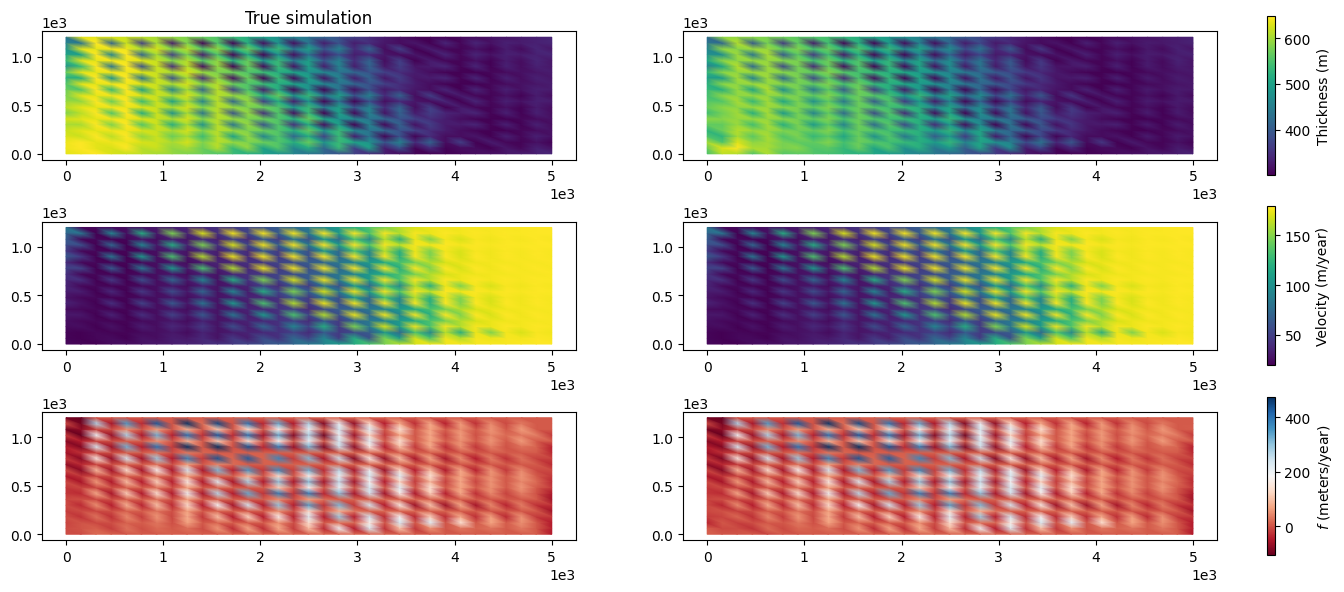

In [108]:
from firedrake import div
import copy
import icepack
import icepack.plot
fig, axes = icepack.plot.subplots(3,2, figsize=(16,7))
step = nt-1
hhtrue = firedrake.Function(Q)
uutrue = firedrake.Function(V)
hhtrue.dat.data[:] = copy.deepcopy(statevec_true[:hdim,step])
colors = firedrake.tripcolor(hhtrue, axes=axes[0][0])
fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")
axes[0][0].set_title("True simulation")

# ploting the velocity field
uutrue.dat.data[:,0] = copy.deepcopy(statevec_true[hdim:2*hdim,step])
uutrue.dat.data[:,1] = copy.deepcopy(statevec_true[2*hdim:3*hdim,step])
colors = firedrake.tripcolor(uutrue, axes=axes[1][0])
fig.colorbar(colors, ax=axes[1], fraction=0.012, pad=0.04, label="Velocity (m/year)")

# ploting the basal shear stress
f = firedrake.interpolate(div(hhtrue*uutrue), Q)
colors = firedrake.tripcolor(f, axes=axes[2][0], cmap="RdBu")
fig.colorbar(colors, ax=axes[2], fraction=0.012, pad=0.04, label=r"$f$ (meters/year)")

# axes[0][1].set_title("EnKF simulation")
# axes[0][1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")
hhenkf = firedrake.Function(Q)
uuenkf = firedrake.Function(V)
hhenkf.dat.data[:] = copy.deepcopy(statevec_ens_mean[:hdim,step])
colors = firedrake.tripcolor(hhenkf, axes=axes[0][1])
# fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")


# ploting the velocity field
uuenkf.dat.data[:,0] = copy.deepcopy(statevec_ens_mean[hdim:2*hdim,step])
uuenkf.dat.data[:,1] = copy.deepcopy(statevec_ens_mean[2*hdim:3*hdim,step])
colors = firedrake.tripcolor(uuenkf, axes=axes[1][1])


# ploting the basal shear stress
f = firedrake.interpolate(div(hhenkf*uuenkf), Q)
colors = firedrake.tripcolor(f, axes=axes[2][1], cmap="RdBu")

Text(0, 0.5, 'thickness (m)')

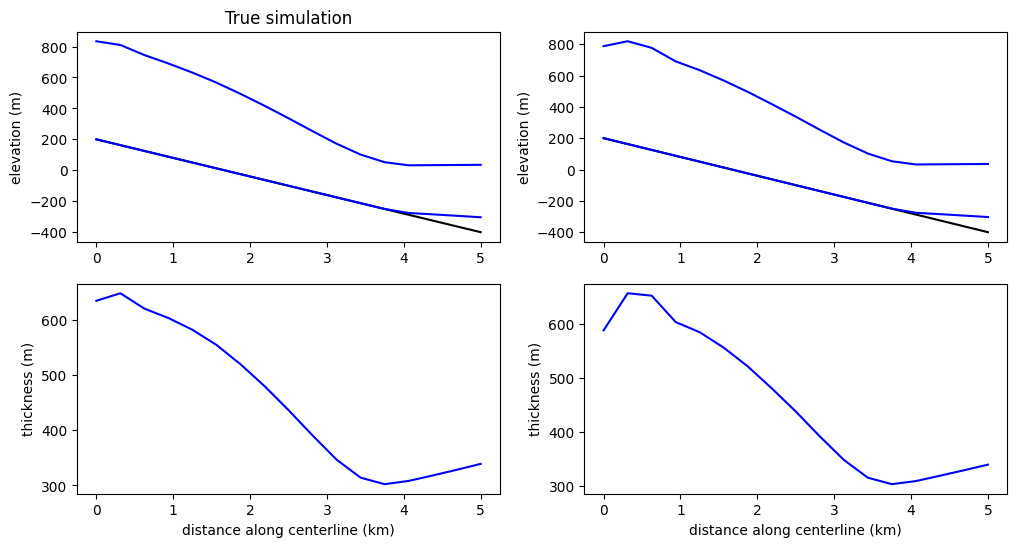

In [109]:
# we can draw some transects through the domain to see what the surface, bed, and ice base elevation look like

xs = np.array([(Lx * k /nx, 0) for k in range(nx + 1)])
s = icepack.compute_surface(thickness = hhtrue, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhtrue.at(xs, tolerance=1e-10))

fig, axes = plt.subplots(2,2, figsize=(12, 6))
axes[0,0].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,0].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,0].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,0].set_xlabel("distance along centerline (km)")
axes[0,0].set_ylabel("elevation (m)")
axes[0,0].set_title("True simulation")

axes[1,0].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,0].set_xlabel("distance along centerline (km)")
axes[1,0].set_ylabel("thickness (m)")


s = icepack.compute_surface(thickness = hhenkf, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhenkf.at(xs, tolerance=1e-10))

axes[0,1].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,1].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,1].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,1].set_xlabel("distance along centerline (km)")
axes[0,1].set_ylabel("elevation (m)")
# axes[0,1].set_title("DEnKF simulation")
# axes[0,1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")

axes[1,1].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,1].set_xlabel("distance along centerline (km)")
axes[1,1].set_ylabel("thickness (m)")

Text(0, 0.5, 'Velocity')

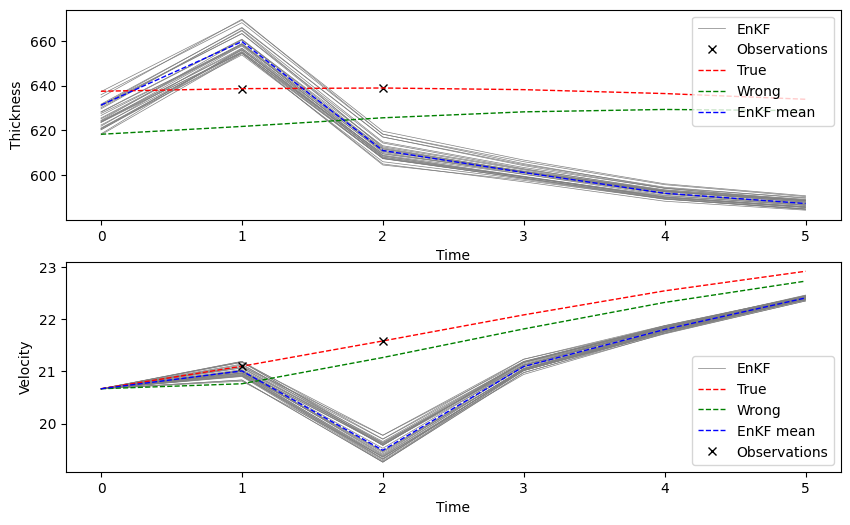

In [112]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

# h_obs = utils_funs.Obs_fun(hu_obs[:hdim,:])
obs_h = w[h_indx,:]


# plot the h middle profile
# h_indx = hens.shape[1]//2
hens = statevec_ens_mean[:hdim,:]
h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]
h_ens_mean = hens[h_indx,:]
h_ens_mem  = statevec_ens_full[h_indx,:,:].T
# h_ob = h_ob[-1,:]
Nens = statevec_ens_full.shape[1]
for ens in range(Nens):
    ax[0].plot(t,h_ens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

# ax[0].plot(ts,h_ens_mem[:,:], lw=0.5, color='k',label="DEnKF ens")
ax[0].plot(t[ind_m],obs_h,'kx',label="Observations")

ax[0].plot(t,h_true,'--r',label='True',linewidth=1)
ax[0].plot(t,h_nurged,'--g',label='Wrong',linewidth=1)
ax[0].plot(t,h_ens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
# ax[0].plot(t[ind_m],hu_ob[1,:],'kx',label='Observations')
ax[0].legend()
# ax[0].set_ylim([350, 500])
# ax[0].set_xlim([1, 250])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Thickness')

# plot the u middle profile
# u_ob = utils_funs.Obs_fun(hu_obs[hdim:2*hdim,:])
# v_ob = utils_funs.Obs_fun(hu_obs[2*hdim:,:])
# uobs = np.sqrt(u_ob**2 + v_ob**2)
u_indx = hdim + h_indx
v_indx = 2*hdim + h_indx
obs_u = w[u_indx,:]
obs_v = w[v_indx,:]
uobs = np.sqrt(obs_u**2 + obs_v**2)
u_true = statevec_true[u_indx,:]
v_true = statevec_true[v_indx,:]
utrue = np.sqrt(u_true**2 + v_true**2)
u_nurge = statevec_nurged[u_indx,:]
v_nurge = statevec_nurged[v_indx,:]
unurge = np.sqrt(u_nurge**2 + v_nurge**2)
u_ens_mean = statevec_ens_mean[u_indx,:]
v_ens_mean = statevec_ens_mean[v_indx,:]
uens_mean = np.sqrt(u_ens_mean**2 + v_ens_mean**2)
u_ens_mem  = statevec_ens_full[u_indx,:,:].T
v_ens_mem  = statevec_ens_full[v_indx,:,:].T
uens_mem = np.sqrt(u_ens_mem**2 + v_ens_mem**2)
for ens in range(Nens):
    ax[1].plot(t,uens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

ax[1].plot(t,utrue,'--r',label='True',linewidth=1)
ax[1].plot(t,unurge,'--g',label='Wrong',linewidth=1)
ax[1].plot(t,uens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
ax[1].plot(t[ind_m],uobs,'kx',label='Observations')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')

In [23]:
np.arange(0,3,0.5)


array([0. , 0.5, 1. , 1.5, 2. , 2.5])

In [33]:
idx = np.linspace(0,3,6).astype(int)
idx_ = np.arange(0,3,1).astype(int)
idx_

array([0, 1, 2])

In [46]:
# from idx pick on values that don't have the same value 
# idx = np.arange(0.2,250,30)
idx = np.linspace(0.2,250,6)
# idx = np.unique(idx)
print(idx, idx.shape)

[2.0000e-01 5.0160e+01 1.0012e+02 1.5008e+02 2.0004e+02 2.5000e+02] (6,)


In [29]:
t = datasets_tw['t']
t[idx]

array([0. , 0. , 0.5, 0.5, 1. , 1.5])

In [30]:
t

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,
        49.5,  50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,
        54. ,  54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,
        58.5,  59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,
        63. ,  63.5,